In [0]:
%%bash
if [ ! -f "app_processes.parquet.7z" ]; then
  wget -q https://www.dropbox.com/s/vywyp1kdvigopqs/app_processes.parquet.7z
  7z e app_processes.parquet.7z app_processes.250.parquet app_processes.250.dtypes.pickle
fi
if [ ! -f "samples.parquet.7z" ]; then
  wget -q https://www.dropbox.com/s/s3vmcugbbo2qaxb/samples.parquet.7z
  7z e samples.parquet.7z
fi
if [ ! -f "battery_details.parquet.7z" ]; then
  wget -q https://www.dropbox.com/s/mgeymwcfm7y09n4/battery_details.parquet.7z
  7z e battery_details.parquet.7z
fi
if [ ! -f "cpu_statuses.parquet.7z" ]; then
  wget -q https://www.dropbox.com/s/oo56nhj8jjfp0ma/cpu_statuses.parquet.7z
  7z e cpu_statuses.parquet.7z
fi
if [ ! -f "settings.parquet.7z" ]; then
  wget -q https://www.dropbox.com/s/h5sc45d0d1odzpl/settings.parquet.7z
  7z e settings.parquet.7z
fi

In [0]:
import pickle
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

In [0]:
%load_ext google.colab.data_table

In [0]:
def load_dtypes(path):
  with open(path, 'rb') as handle:
    return pickle.load(handle)


def save_df(df, path, compression='snappy', use_dictionary=True):
  """
  Save a pandas DataFrame to a parquet file
  """
  try:
    df.to_parquet(path, compression=compression,
                  use_dictionary=use_dictionary)
  except Exception as e:
    print(e)


def load_df(path, columns=None, use_threads=True, strings_to_categorical=True):
  """
  Load a parquet file and returns a pandas DataFrame
  """
  try:
    table = pq.read_table(path, columns=columns, use_threads=use_threads)
    return table.to_pandas(strings_to_categorical=strings_to_categorical)
  except Exception as e:
      print(e)

In [0]:
df = load_df('app_processes.250.parquet')

In [0]:
df = df.astype(load_dtypes('app_processes.250.dtypes.pickle'))
df['name'] = df['name'].str.split(':').map(lambda x: x[0])

In [0]:
df = df.reset_index(drop=True)

In [0]:
blacklist = pd.read_csv('system-apps.csv')['name']
sources = ['com.mansoon.batterydouble', 'com.hmatalonga.greenhub']

In [0]:
df = df.dropna()
df = df[~df['name'].isin(blacklist)]
df = df[~df['name'].isin(sources)]
df = df.reset_index(drop=True)
df = df.drop(['is_system_app'], axis=1)
df = df.rename(columns={'sample_id':'fk'})

## Merge tables
### Samples

In [0]:
columns = ['id', 'battery_state',
           'battery_level', 'network_status', 'screen_brightness', 'screen_on']
data = load_df('samples.parquet', columns=columns)

In [0]:
df = df.merge(data, left_on='fk', right_on='id')
df = df.drop(['id'], axis=1)

### Battery details

In [0]:
battery_dtypes = {
    'charger': 'category',
    'current_average': 'int64',
    'health': 'category',
    'sample_id': 'uint32',
    'temperature': 'float32',
    'voltage': 'float32'
}
columns = ['sample_id', 'charger', 'current_average',
           'health', 'temperature', 'voltage']
data = load_df('battery_details.parquet', columns=columns).astype(battery_dtypes)

In [0]:
data['voltage'] = data['voltage'].round(3)
data['temperature'] = data['temperature'].astype(np.float32).round(3)

In [0]:
df = df.merge(data, left_on='fk', right_on='sample_id')
df = df.drop(['sample_id'], axis=1)

### CPU statuses

In [0]:
data = load_df('cpu_statuses.parquet', columns=['sample_id', 'usage'])

In [0]:
df = df.merge(data, left_on='fk', right_on='sample_id')
df = df.drop(['sample_id'], axis=1)

### Settings

In [0]:
data = load_df('settings.parquet').astype(load_dtypes('settings.dtypes.pickle'))

In [0]:
df = df.merge(data, left_on='fk', right_on='sample_id')
df = df.drop(['sample_id', 'unknown_sources', 'developer_mode'], axis=1)

### Drop duplicated rows

In [0]:
subset = ['name', 'importance', 'version_code', 'bluetooth_enabled',
          'location_enabled', 'power_saver_enabled', 'flashlight_enabled',
          'battery_state', 'battery_level', 'network_status',
          'screen_brightness', 'screen_on', 'health', 'charger', 'usage']
envs = df.drop_duplicates(subset=subset)

In [0]:
envs = df.reset_index(drop=True)

In [21]:
envs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397008 entries, 0 to 397007
Data columns (total 21 columns):
fk                     397008 non-null uint32
name                   397008 non-null object
application_label      397008 non-null category
importance             397008 non-null category
version_code           397008 non-null uint32
battery_state          397008 non-null category
battery_level          397008 non-null uint8
network_status         397008 non-null category
screen_brightness      397008 non-null int64
screen_on              397008 non-null uint8
charger                397008 non-null category
current_average        397008 non-null int64
health                 397008 non-null category
temperature            397008 non-null float32
voltage                397008 non-null float32
usage                  397008 non-null float32
bluetooth_enabled      397008 non-null uint8
location_enabled       397008 non-null uint8
power_saver_enabled    397008 non-null uint8
flashli

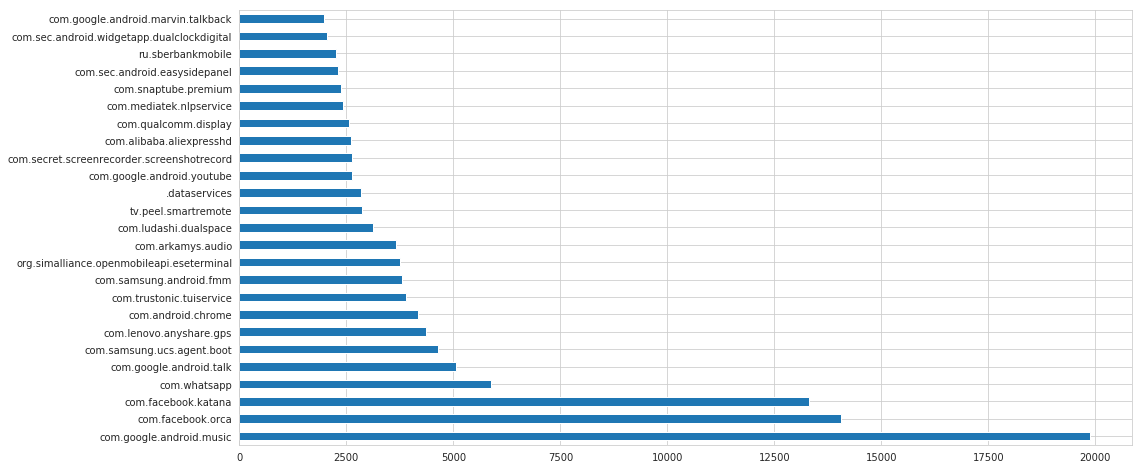

In [22]:
envs['name'].value_counts()[:25].plot.barh(figsize=(16,8))

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397008 entries, 0 to 397007
Data columns (total 21 columns):
fk                     397008 non-null uint32
name                   397008 non-null object
application_label      397008 non-null category
importance             397008 non-null category
version_code           397008 non-null uint32
battery_state          397008 non-null category
battery_level          397008 non-null uint8
network_status         397008 non-null category
screen_brightness      397008 non-null int64
screen_on              397008 non-null uint8
charger                397008 non-null category
current_average        397008 non-null int64
health                 397008 non-null category
temperature            397008 non-null float32
voltage                397008 non-null float32
usage                  397008 non-null float32
bluetooth_enabled      397008 non-null uint8
location_enabled       397008 non-null uint8
power_saver_enabled    397008 non-null uint8
flashli

In [0]:
df = df.drop(['fk'], axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397008 entries, 0 to 397007
Data columns (total 20 columns):
name                   397008 non-null object
application_label      397008 non-null category
importance             397008 non-null category
version_code           397008 non-null uint32
battery_state          397008 non-null category
battery_level          397008 non-null uint8
network_status         397008 non-null category
screen_brightness      397008 non-null int64
screen_on              397008 non-null uint8
charger                397008 non-null category
current_average        397008 non-null int64
health                 397008 non-null category
temperature            397008 non-null float32
voltage                397008 non-null float32
usage                  397008 non-null float32
bluetooth_enabled      397008 non-null uint8
location_enabled       397008 non-null uint8
power_saver_enabled    397008 non-null uint8
flashlight_enabled     397008 non-null uint8
nfc_enab

In [0]:
save_df(df, 'random-forest-apps.parquet')